In [1]:
!pip install pyarrow

     |████████████████████████████████| 26.7 MB 5.2 MB/s            �█████████▊         | 19.0 MB 5.2 MB/s eta 0:00:02


In [2]:
!pip3 install torch==1.10.1+cpu  -f https://download.pytorch.org/whl/cpu/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     |████████████████████████████████| 199.3 MB 63 kB/s               


In [3]:
!pip3 install transformers

     |████████████████████████████████| 3.5 MB 4.6 MB/s            
     |████████████████████████████████| 596 kB 72.3 MB/s            
     |████████████████████████████████| 67 kB 8.0 MB/s             
     |████████████████████████████████| 895 kB 82.3 MB/s            
     |████████████████████████████████| 748 kB 62.5 MB/s            
     |████████████████████████████████| 6.8 MB 53.5 MB/s            
     |████████████████████████████████| 306 kB 76.7 MB/s            


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

from transformers import pipeline

In [6]:
import warnings
warnings.filterwarnings("ignore")


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
fakeNews = pd.read_feather('https://github.com/thousandoaks/TopicsInDataAnalysisDataStore/blob/main/train.ftr?raw=true')

In [8]:
fakeNews.sample(3)

,id,title,author,text,label
7708,7708,Vicente Fox Trolls Trump on Twitter: ’Are You ...,Alex Swoyer,Former President of Mexico Vicente Fox took to...,0
16762,16762,Life: Now It’s Mustard’s Time To Shine,None,Now It’s Mustard’s Time To Shine Posted today ...,1
18550,18550,Is Your VACCINATED Child a ‘Haz Mat’?,Heather Callaghan,By Catherine J Frompovich What a question to a...,1


# 1. Basic Exploratory Analysis

In [9]:
fakeNews.groupby('label').count()

,id,title,author,text
label,,,,
0,10387,10387,10361,10387
1,10413,9855,8482,10374


## 1.1. Emotion Analysis
### Is there any relationship between emotions and fakeness ?

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [11]:
#classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=False)

In [12]:
fakeNews.dropna(subset=['title'],inplace=True)

In [13]:
fakeNewsSample=fakeNews.sample(40)

In [14]:
#classifier(mini['title'].tolist())

In [15]:
import time
start_time = time.time()
fakeNewsSample['text.classification']=fakeNewsSample['title'].apply(lambda x:classifier(x))

print("--- %s seconds ---" % (time.time() - start_time))

--- 5.501216411590576 seconds ---


In [16]:
fakeNewsSample['emotion.label']=fakeNewsSample['text.classification'].apply(lambda x:x[0]['label'])
fakeNewsSample['emotion.intensity']=fakeNewsSample['text.classification'].apply(lambda x:x[0]['score'])

In [17]:
fakeNewsSample.head(3)

,id,title,author,text,label,text.classification,emotion.label,emotion.intensity
10528,10528,Flurry of Settlements Over Toxic Mortgages May...,Landon Thomas Jr. and Jack Ewing,European banks have rushed to cut deals with p...,0,"[{'label': 'anger', 'score': 0.8179473876953125}]",anger,0.817947
9818,9818,"Aleppo, Donald Trump, Istanbul: Your Morning B...",Charles McDermid,Good morning. Here’s what you need to know: •...,0,"[{'label': 'anger', 'score': 0.4787552058696747}]",anger,0.478755
4387,4387,Motorcycling Without the Mansplaining - The Ne...,Lily Brooks-Dalton,"We’re fresh over the Canadian border, in a sup...",0,"[{'label': 'fear', 'score': 0.582007884979248}]",fear,0.582008


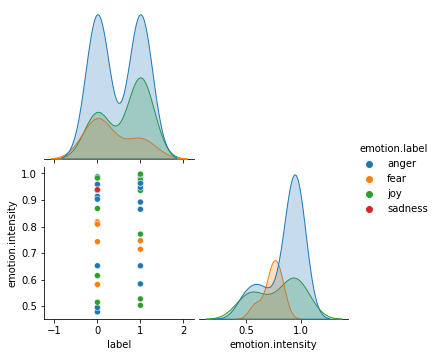

In [18]:
sns.pairplot(fakeNewsSample[['label','emotion.label','emotion.intensity']], hue="emotion.label",corner=True)

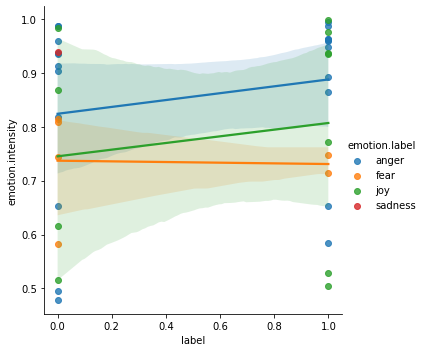

In [19]:
g = sns.lmplot(
    data=fakeNewsSample[['label','emotion.label','emotion.intensity']],
    x="label", y="emotion.intensity", hue="emotion.label",
    height=5
)

## Are emotions useful to spot FakeNews ??
### Tip: have a look at the histograms

## 1.2. text Analysis
### Is there any relationship between text characteristics and fakeness ?

In [20]:
fakeNews['title.length']=fakeNews['title'].apply(lambda x:len(x))

In [21]:
fakeNews.dropna(subset=['text'],inplace=True)

In [22]:
fakeNews['text.length']=fakeNews['text'].apply(lambda x:len(x))

In [23]:
fakeNews[['label','text.length','title.length']].head()

,label,text.length,title.length
0,1,4930,81
1,0,4160,55
2,1,7692,33
3,1,3237,63
4,1,938,93


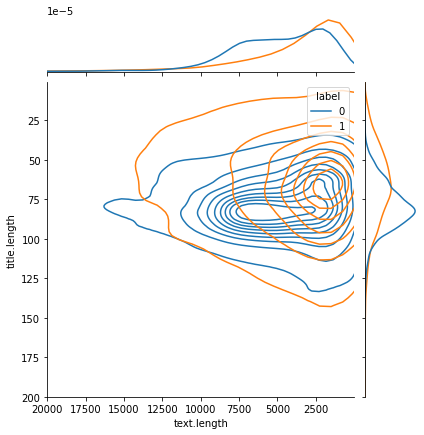

In [24]:
g = sns.jointplot(
    data=fakeNews[['label','text.length','title.length']],
    x="text.length", y="title.length", hue="label",xlim=20000,ylim=200,
    kind="kde",
)

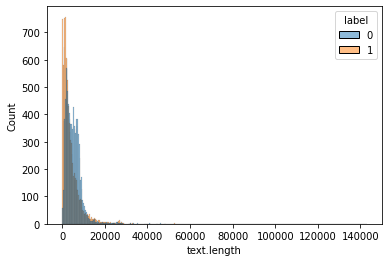

In [25]:
sns.histplot(data=fakeNews[['label','text.length','title.length']], x="text.length", hue="label")

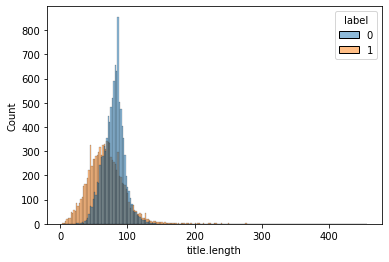

In [26]:
sns.histplot(data=fakeNews[['label','text.length','title.length']], x="title.length", hue="label")

## Thoughts ??

## 1.3. Text readibility

In [27]:
!pip install -U spacy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 6.0 MB 4.8 MB/s            
     |████████████████████████████████| 628 kB 65.8 MB/s            
     |████████████████████████████████| 10.1 MB 50.5 MB/s            
     |████████████████████████████████| 9.9 MB 43.4 MB/s            
     |████████████████████████████████| 125 kB 42.8 MB/s            
     |████████████████████████████████| 181 kB 46.3 MB/s            
     |████████████████████████████████| 42 kB 2.5 MB/s             
     |████████████████████████████████| 451 kB 71.8 MB/s            
     |████████████████████████████████| 58 kB 8.6 MB/s             
  Attempting uninstall: typing-extensions
    Found exist

In [28]:
!pip install spacy-readability

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 49 kB 3.2 MB/s             
     |████████████████████████████████| 10.4 MB 9.1 MB/s            
     |████████████████████████████████| 1.0 MB 68.6 MB/s            
     |████████████████████████████████| 184 kB 77.2 MB/s            
     |████████████████████████████████| 192 kB 79.0 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for ujson: filename=ujson-1.35-cp37-cp37m-linux_x86_64.whl size=69664 sha256=18ca0e665147e8e4da71deec08664d0e6c4c96597c82e87643170438d06110d1
  Stored in directory: /home/jovyan/.cache/pip/wheels/55/e8/7e/e36b183f3e654b73fc04eb1b656ad3c2773077dd531cb35c4d
Successfully built 

In [29]:
import spacy
from spacy_readability import Readability

In [30]:
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 12.0 MB 4.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=a45b58d40a14999735afe862e686e2db4c20d0ee4df26c3cbadd26c9ff017802
  Stored in directory: /home/jovyan/.cache/pip/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [36]:
import en_core_web_sm

In [38]:



nlp2 = en_core_web_sm.load()
nlp2.add_pipe(Readability())


In [39]:
doc = nlp2("I am some really difficult text to read because I use obnoxiously large words.")

In [40]:
doc._.flesch_kincaid_grade_level

8.412857142857145

In [41]:
fakeNewsSample2=fakeNewsSample.sample(30)

In [42]:
fakeNewsSample2['text.nlp']=fakeNewsSample2['text'].apply(lambda x:nlp2(x))
fakeNewsSample2['title.nlp']=fakeNewsSample2['title'].apply(lambda x:nlp2(x))

In [43]:
fakeNewsSample2['text.automated_readability_index']=fakeNewsSample2['text.nlp'].apply(lambda x:x._.automated_readability_index)
fakeNewsSample2['title.automated_readability_index']=fakeNewsSample2['title.nlp'].apply(lambda x:x._.automated_readability_index)

In [44]:
fakeNewsSample2['text.flesch_kincaid_reading_ease']=fakeNewsSample2['text.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)
fakeNewsSample2['title.flesch_kincaid_reading_ease']=fakeNewsSample2['title.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)

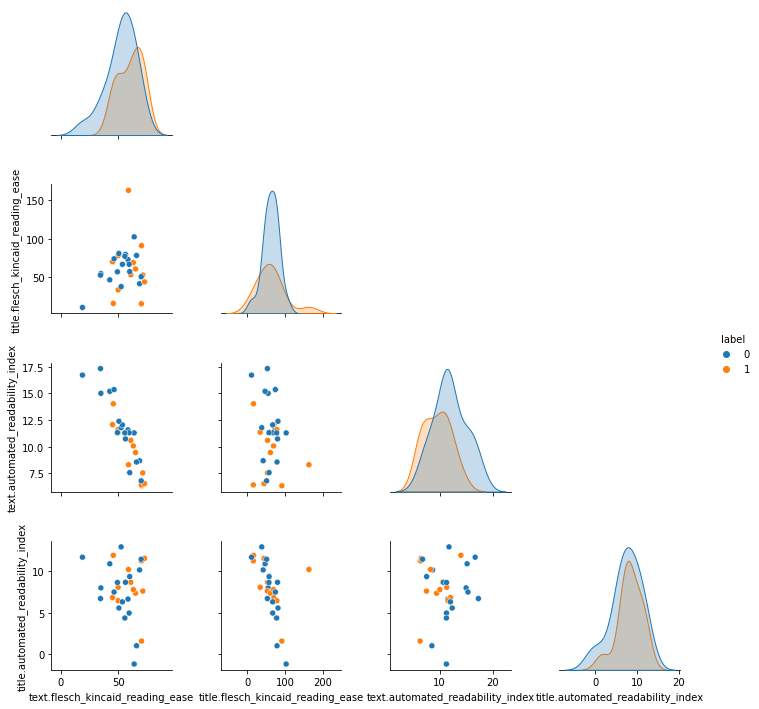

In [45]:
sns.pairplot(fakeNewsSample2[['label','text.flesch_kincaid_reading_ease','title.flesch_kincaid_reading_ease','text.automated_readability_index','title.automated_readability_index']], hue="label",corner=True)

## 1.4. Text entities

In [46]:
text='Hi there, I am in Japan'

In [47]:
doc=nlp2(text)

In [48]:
for ent in doc.ents:
    print(ent.text,  ent.label_)

Japan GPE


In [49]:
fakeNewsSample2['title.entities']=fakeNewsSample2['title.nlp'].apply(lambda x:[e.label_ for e in x.ents])


In [50]:
fakeNewsSample2[fakeNewsSample2['label']==0]['title.entities']

17285               [GPE, ORG]
2073                        []
9818       [PERSON, GPE, TIME]
9717          [ORG, DATE, ORG]
6705                  [PERSON]
13188                 [PERSON]
13651            [PERSON, ORG]
4664                        []
742             [PERSON, DATE]
7429                [GPE, ORG]
4387                        []
20503                       []
10528                       []
3528            [PERSON, NORP]
12664                    [GPE]
7989        [PERSON, GPE, ORG]
15185                       []
1563     [PERSON, PERSON, ORG]
Name: title.entities, dtype: object

In [51]:
notFakeEntities=pd.DataFrame()
notFakeEntities['entity']=fakeNewsSample2[fakeNewsSample2['label']==0]['title.entities'].explode()
notFakeEntities['label']=0

In [53]:
notFakeEntities.head(3)

,entity,label
17285,GPE,0
17285,ORG,0
2073,NaN,0


In [54]:
FakeEntities=pd.DataFrame()
FakeEntities['entity']=fakeNewsSample2[fakeNewsSample2['label']==1]['title.entities'].explode()
FakeEntities['label']=1

In [55]:
FakeEntities.head(3)

,entity,label
3913,PERSON,1
3913,ORG,1
13358,NaN,1


In [56]:
notFakeEntities.groupby('entity').count().reset_index()

,entity,label
0,DATE,2
1,GPE,5
2,NORP,1
3,ORG,7
4,PERSON,9
5,TIME,1


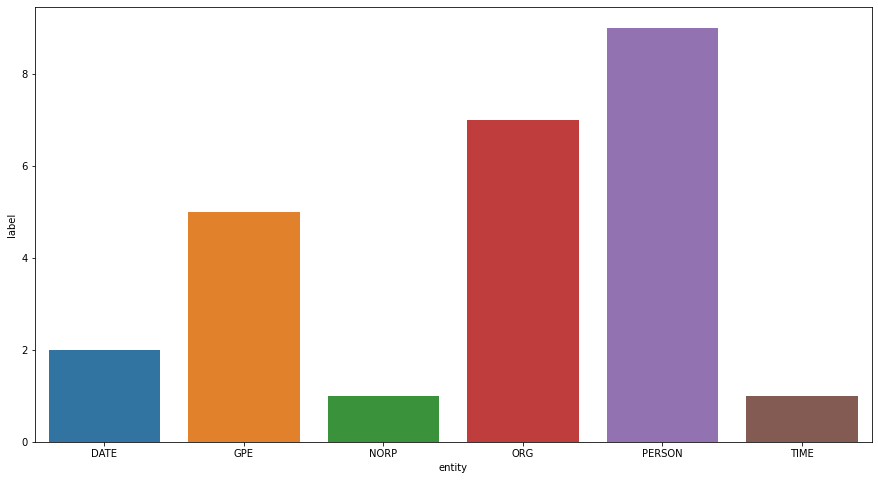

In [57]:
plt.figure(figsize=(15,8))
sns.barplot( x='entity',y='label',data=notFakeEntities.groupby('entity').count().reset_index())

In [58]:
FakeEntities.groupby('entity').count()

,label
entity,
CARDINAL,1
GPE,1
LOC,1
NORP,1
ORG,3
PERSON,5
WORK_OF_ART,3


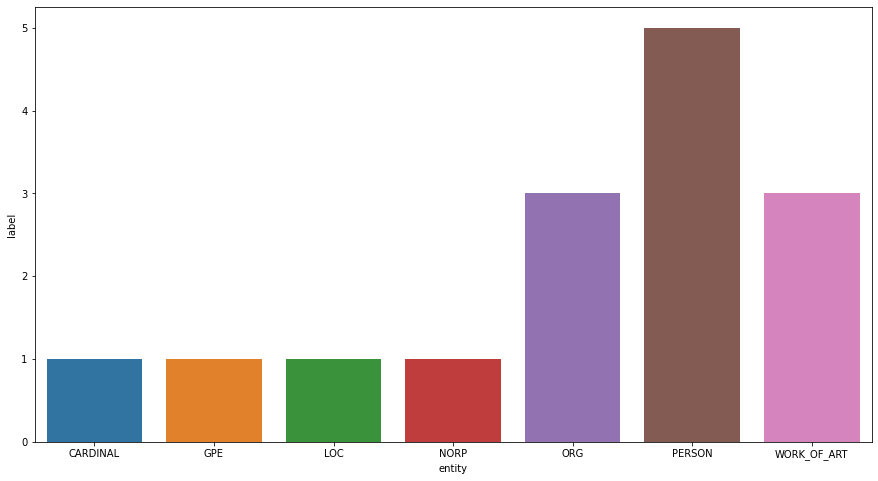

In [59]:
plt.figure(figsize=(15,8))
sns.barplot( x='entity',y='label',data=FakeEntities.groupby('entity').count().reset_index())

# Thoughts ??